In [1]:
from tqdm import auto
import matplotlib.pyplot as plt

In [2]:
%run physionet_preprocessing.py --classif --quantization=1

Using downloaded and verified file: data/physionet/PhysioNet/raw/Outcomes-a.txt
Using downloaded and verified file: data/physionet/PhysioNet/raw/set-a.tar.gz?download
Processing set-a.tar.gz?download...
Using downloaded and verified file: data/physionet/PhysioNet/raw/set-b.tar.gz?download
Processing set-b.tar.gz?download...
Done!
{'dataset_obj': Dataset PhysioNet
    Number of datapoints: 4000
    Split: train
    Root Location: data/physionet
    Quantization: 1.0
    Reduce: average
, 'train_dataloader': <generator object inf_generator at 0x7fbf7c6f2040>, 'test_dataloader': <generator object inf_generator at 0x7fbf7c39fe40>, 'input_dim': 41, 'n_train_batches': 64, 'n_test_batches': 1, 'attr': ['Age', 'Gender', 'Height', 'ICUType', 'Weight', 'Albumin', 'ALP', 'ALT', 'AST', 'Bilirubin', 'BUN', 'Cholesterol', 'Creatinine', 'DiasABP', 'FiO2', 'GCS', 'Glucose', 'HCO3', 'HCT', 'HR', 'K', 'Lactate', 'Mg', 'MAP', 'MechVent', 'Na', 'NIDiasABP', 'NIMAP', 'NISysABP', 'PaCO2', 'PaO2', 'pH', 'Pla

In [3]:
dataset = data_obj['dataset_obj']

In [4]:
max_length = 0 
for data in dataset:
    pid, t, x, mask, y = data
    max_length_i = mask.sum(dim=0).max().item()
    max_length = max(max_length_i, max_length)

In [5]:
x_dim = data_obj['input_dim']
N = len(dataset)
max_length = int(max_length)

In [6]:
times = torch.zeros((N, max_length, x_dim))
masks = torch.zeros((N, max_length, x_dim))
observations = torch.zeros((N, max_length, x_dim))
labels = torch.zeros((N,))

In [7]:
for i,data in enumerate(auto.tqdm(dataset)):
    pid, t, x, mask, y = data
    for j in range(x_dim):
        mask_x = mask[:,j]
        length = int(mask_x.sum().item())
        times[i,:length,j] = torch.masked_select(t,mask_x==1.0)
        observations[i,:length,j] = torch.masked_select(x[:,j],mask_x==1.0)
        masks[i,:length,j] = 1
    labels[i]=y
    

  0%|          | 0/4000 [00:00<?, ?it/s]

In [8]:
x_labels = np.array(data_obj['attr'])

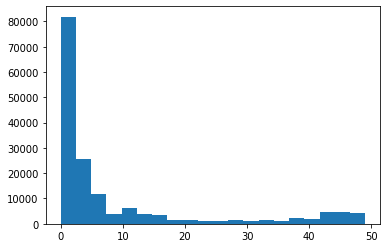

In [9]:
length = masks.sum(dim=1).flatten().numpy()
_=plt.hist(length,bins=20)

In [10]:
static_features = ['Age','Gender','Height','ICUType','Weight']
static_dims, = np.where(np.isin(x_labels,static_features))
for dim in static_dims:
    observations[:,:,dim] = observations[:,[0],dim].expand((-1,max_length))

In [11]:
np.savez_compressed('physionet.npz', x = observations,t=times, mask=masks, y = labels, labels=x_labels)